# Final report
>                             Anil Kumar and Jahnavi Malagavalli

This is a report on all the topics we've worked on for these past 8 weeks.
This notebook highlights the insights gained on a specific topic and any code written by us on that subject aimed towards testing new ideas or just verifying the results given. All papers studied and packages used are referred.  

These are the topics covered
1. Compressive sensing.
2. SVD,K-SVD,kernel K-SVD,Linearized kernel dictionary learning.
4. HDF5,Random sampling and Multi-level wavelet decomposition.
5. Pathology
    * Various visualization methods and available softwares
    * Breast biopsy
        - Tissue types,diseases and diagnosis
        - ROI prediction and classification
6.  Python package for big data management
    * Converts pathology datasets,cardiac and GEMS datasets to HDF5 formats with chunking for better access
    * Various random and uniform sampling functions available for all the said datasets
     * Better visualization using only sampling
     * ROI predictions(Future)
     

## Compressive sensing


### Papers referred:
1. An  Introduction  to  Compressive  Sampling  by  Emmanuel  J.  Candes  and  Michael  B. Wakin. 
    > Link: https://authors.library.caltech.edu/10092/1/CANieeespm08.pdf
2. Compressive  Sensing:  A  new  Framework  for  Imaging  by  Richard  Baraniuk,  Justin Romberg and Robert Nowak.
    > Link: http://www.cs.jhu.edu/~misha/ReadingSeminar/Papers/Baraniuk06.pdf
3. On asymtotic structure in compressed sensing.
    > Link: https://arxiv.org/pdf/1406.4178
4. Here are the links that we visited
    - ConvCSNet: A Convolutional Compressive SensingFramework Based on Deep Learning
        > Link: https://arxiv.org/abs/1801.10342
    - Medium article: https://medium.com/@LeoKTam/compressed-sensing-and-deep-learning-revisited-414e0161cfe2

### Code
Packages used:
* numpy (For arrays)
* scipy (For cosine transform and inverse cosine transforms)
* matplotlib(for plots)
* cvxpy (To solve convex optimization problems)
* PIL (For importing images)

The following code applies compressive sensing to 1D and 2D(Image) signals and results are displayed below.

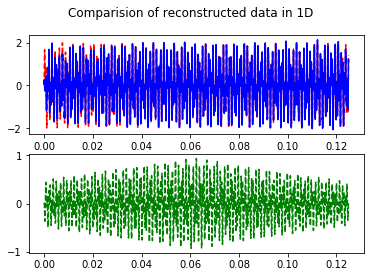

In [11]:
#1D signal
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
from PIL import Image
import cvxpy as cvx

n = 5000
t = np.linspace(0, 1/8, n)
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t)
yt = spfft.dct(y, norm='ortho')

# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]

# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]

# do L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == y2]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=False)


# reconstruct signal
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)
corr = signal.correlate(y,sig,mode="same")/5000
fig, axs = plt.subplots(2)
fig.suptitle('Comparision of reconstructed data in 1D')
axs[0].plot(t,y,'r--',t,sig,'b')
axs[1].plot(t,corr,'g--')
plt.show()

The following code only takes a downscaled version and grayscale version of the whole image due to the constraints on the computational power of my laptop.

In [2]:
#2D image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
from PIL import Image
import cvxpy as cvx

print("2D")

def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# read original image and downsize for speed
Xorig = Image.open('data/google.jpg').convert('L')
X = Xorig.resize((72,72),Image.ANTIALIAS)
print(X)
"""
Xorig = spimg.imread('/home/anil/Desktop/google.jpg', flatten=True, mode='L')
 # read in grayscale
X = spimg.zoom(Xorig, 0.04)
ny,nx = X.shape"""
im = np.array(X)

ny,nx = X.size
X = im
print(ny)
print(nx)
print(im.shape)
# extract small sample of signal
k = np.round(nx * ny * 0.5) 
# 50% sample
k = int(k)
nx = int(nx)
ny = int(ny)
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]
b = np.expand_dims(b, axis=1)

# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron

# do L1 optimization
vx = cvx.Variable((nx * ny,1))
objective = cvx.Minimize(cvx.norm(vx, 1))
print(vx.value)
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=False)
Xat2 = np.array(vx.value).squeeze()

# reconstruct signal
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = idct2(Xat)
# confirm solution
if not np.allclose(X.T.flat[ri], Xa.T.flat[ri]):
    print('Warning: values at sample indices don\'t match original.')

# create images of mask (for visualization)
mask = np.zeros(X.size)
mask.T.flat[ri] = 255
Xm = 255 * np.ones(X.size)
Xm.T.flat[ri] = X.T.flat[ri]

print(Xa)
Image.fromarray(Xa).show()


2D
<PIL.Image.Image image mode=L size=72x72 at 0x7F2F50E28940>
72
72
(72, 72)
None
[[255.00000106 255.0000004  245.44248334 ... 255.00000074 259.53457835
  254.99999951]
 [254.99999999 260.11162799 244.46948411 ... 255.00000024 254.99999977
  255.00000063]
 [255.00000011 239.667516   255.00000062 ... 248.5645669  251.5382901
  255.89536876]
 ...
 [258.77344448 254.99999955 254.99999991 ... 248.5174484  254.19807103
  254.99999897]
 [254.99999926 252.91378861 254.99999988 ... 255.00000073 253.08675266
  243.91869407]
 [255.00000058 254.99999991 248.63821823 ... 254.99999967 260.00367194
  240.68874689]]


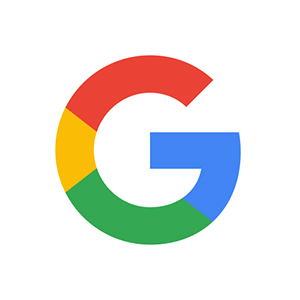

In [3]:
from IPython.display import Image
Image(filename='data/google.jpg',width=72,height=72)

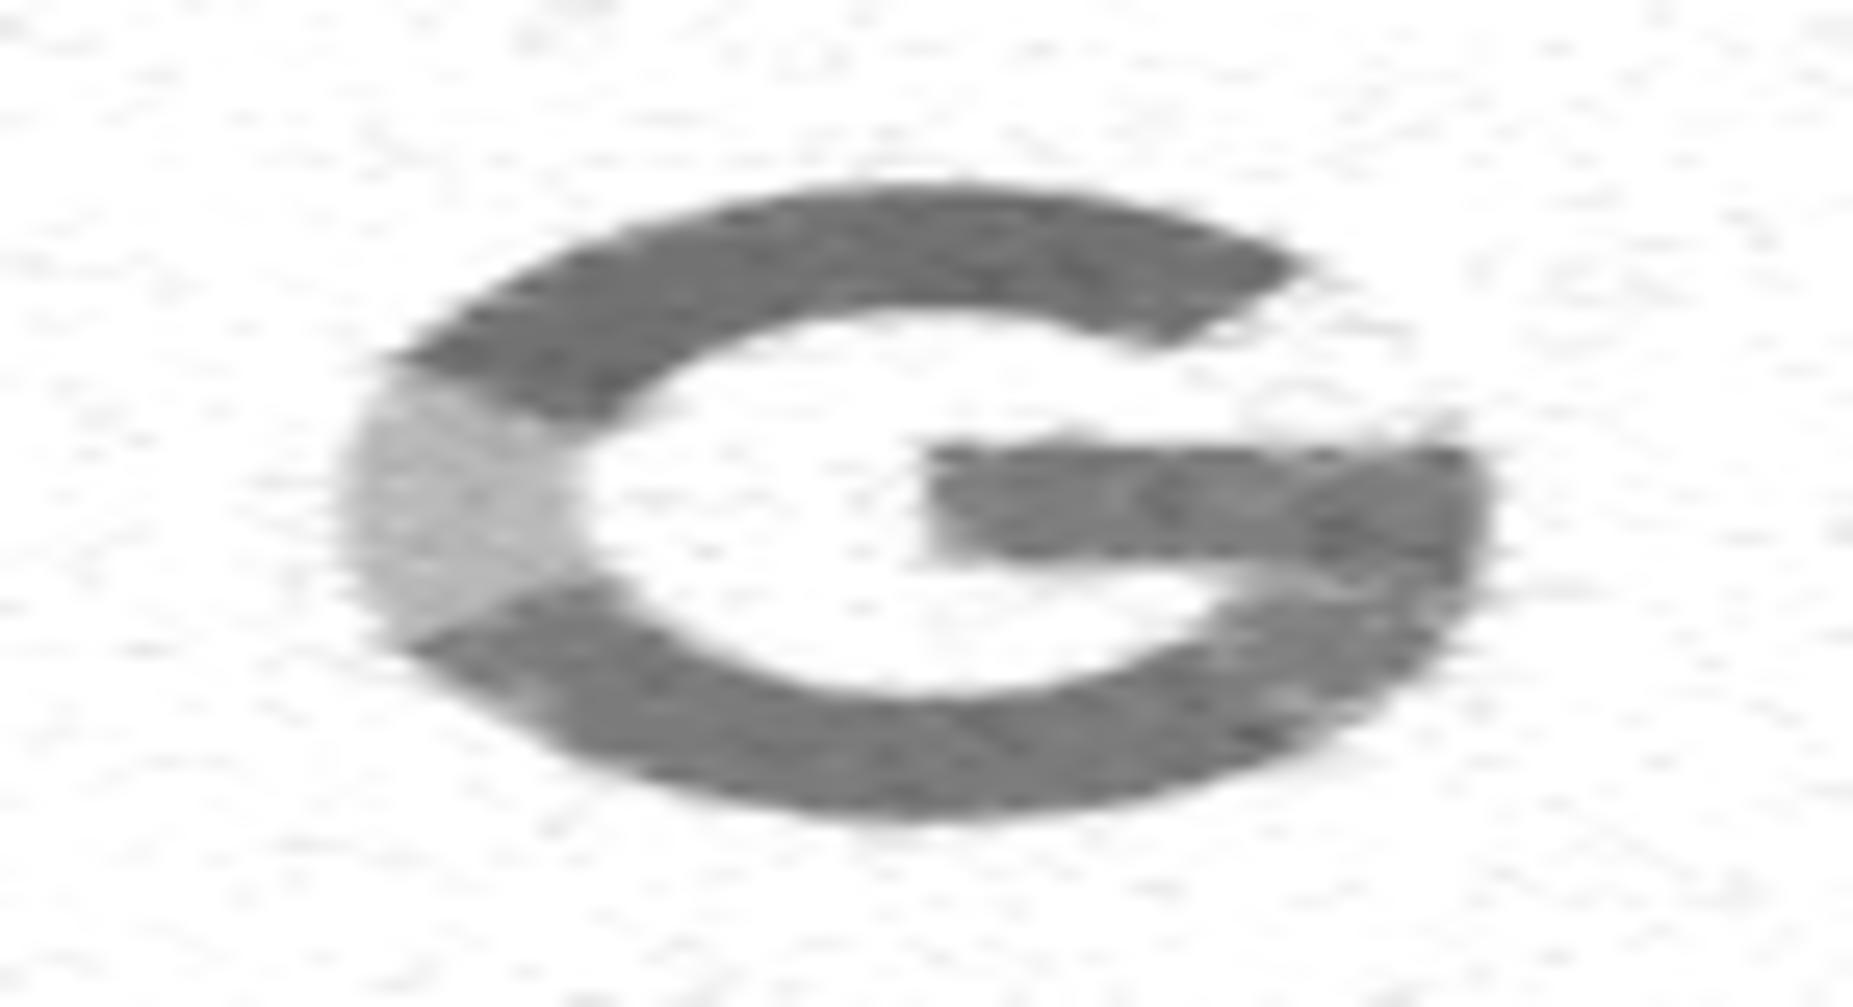

In [4]:
Image(filename='data/output.jpg',width=72,height=72)


## SVD,K-SVD,Kernel K-SVD, Linearized kernel K-SVD

### K-SVD
- Coursera video: https://www.youtube.com/watch?v=-Y_Y4e-EKT0
> Research paper: https://ieeexplore.ieee.org/document/1710377
- Matlab code: http://www.cs.technion.ac.il/~ronrubin/software.html

### Kernel K-SVD
Improved classification accuracy as this preserves the non linearity of data,however, it requires the storage and handling of a very large kernel matrix.
> Research paper: https://www.researchgate.net/profile/NM_Nasrabadi/publication/261091073_Kernel_dictionary_learning/links/54ece6a10cf27fbfd771bf47/Kernel-dictionary-learning.pdf

### Linearized kernel dictionary learning
A detailed explanation of kernel dictionary learning which covers K-SVD,Kernel K-SVD, their drawbacks and proposes a method called linearized kernel K-SVD which uses virtual samples to learn instead of kernel matrix. It has a preprocessing stage thet creates new virtual training and test samples followed by a normal dictionary learning.It employs Nystrom method for the low rank approximation.
> Research paper: https://arxiv.org/pdf/1509.05634

Code: Akshay and I implemented a part of the pseudo code algorithms specified in the above research papers in matlab.

## HDF5, random sampling and multi-level wavelet decomposition 

### HDF5
I wrote a summary on a python implementation of HDF5 file format called h5py
> Link: https://mahindraecolecentrale-my.sharepoint.com/:w:/g/personal/anilkumar170511_mechyd_ac_in/Ec4pp3gjYu9CmXZPZPSXj6QBUH7NOlwWkmyPOiPqeF0rjA?e=3utbuF

### Uniform Random Sampling

 1. Quasi random sequences:
We can generate this sequence in some methods:
   * Halton sequence: These sequences use different prime bases to form successively finer uniform partitions of the unit interval in each dimension. 
   * Sobol sequence: These sequences use a base of 2 to form successively finer uniform partitions of the unit interval and then reorder the coordinates in each dimension.

Packages used:
   * chaospy

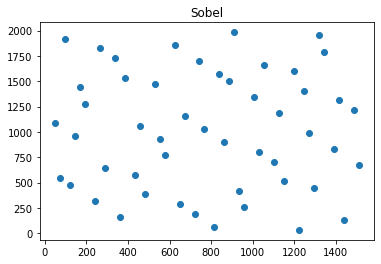

In [5]:
#QMC function code is written by Jahnavi
import chaospy.distributions.sampler.sequences as cdss
import numpy as np
import matplotlib.pyplot as plt

# Parameters :
    #technique : 1(Halton)/2(Sobol)
    #count : no of points to be generated
    #Vmax : it contains the list of the bounds for every dimnesion (e.g [Xmax,Ymax] if dim=2)
    #dim : dimension
# Return Value :
    # V : list (e.g [X[:],Y[:]] if dim=2)
    
#Quasi-Monte Carlo methods
def QMC(technique,count,Vmax,dim):
    for l in range(1):
        V=[]
        if np.size(Vmax)==dim:
            # Halton sequence
            if technique==1:
                points_norm = cdss.halton.create_halton_samples(order=count, dim=dim, burnin=None, primes=[2 for i in range(dim)])
                points=np.array(points_norm).T
                for i in range(dim):
                    V.append((points[:,i]*Vmax[i]).astype(int)) 
            # Sobol sequence
            elif technique==2:
                points_norm = cdss.sobol.create_sobol_samples(order=count,dim=dim,seed=None)
                points=np.array(points_norm).T
                for i in range(dim):
                    V.append((points[:,i]*Vmax[i]).astype(int)) 

            else:
                print("only two techinques are present i.e 1/2")
        else:
            print("size of the Vmax is not equal to dim")
        return V
    
lists = QMC(2,50,[1536,2048],2)
plt.scatter(lists[0],lists[1])
plt.title("Sobel")
plt.show()

2. Random accessing of chunks
    * **Case 1** :
    Here we access stored hdfs chunks randomly using qmc points,point:(top left x coordinate and the y coordinate of the chunk). So no intersection between chunks.chunk_size=(100,100,3)
    
    The below figure represents the chunks accessed from the image data matrix using Case1 technique.Where x,y axis represents x and y dimensions of the given biopsy image data matrix
    
    QMC used: Halton Sequence

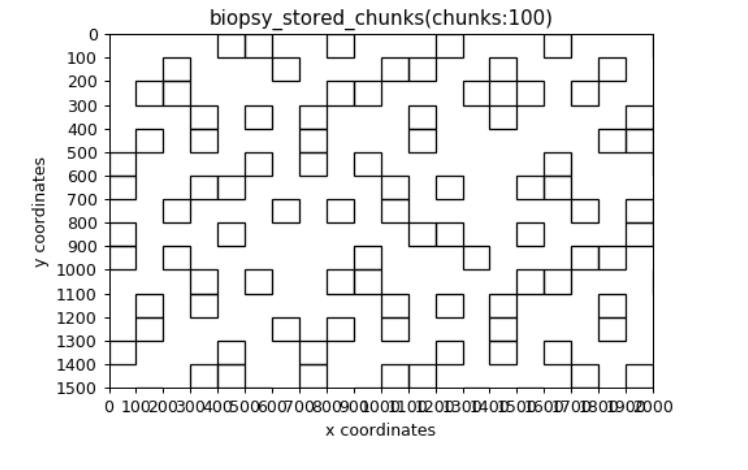

In [6]:
from IPython.display import Image
Image(filename='data/case1.png')

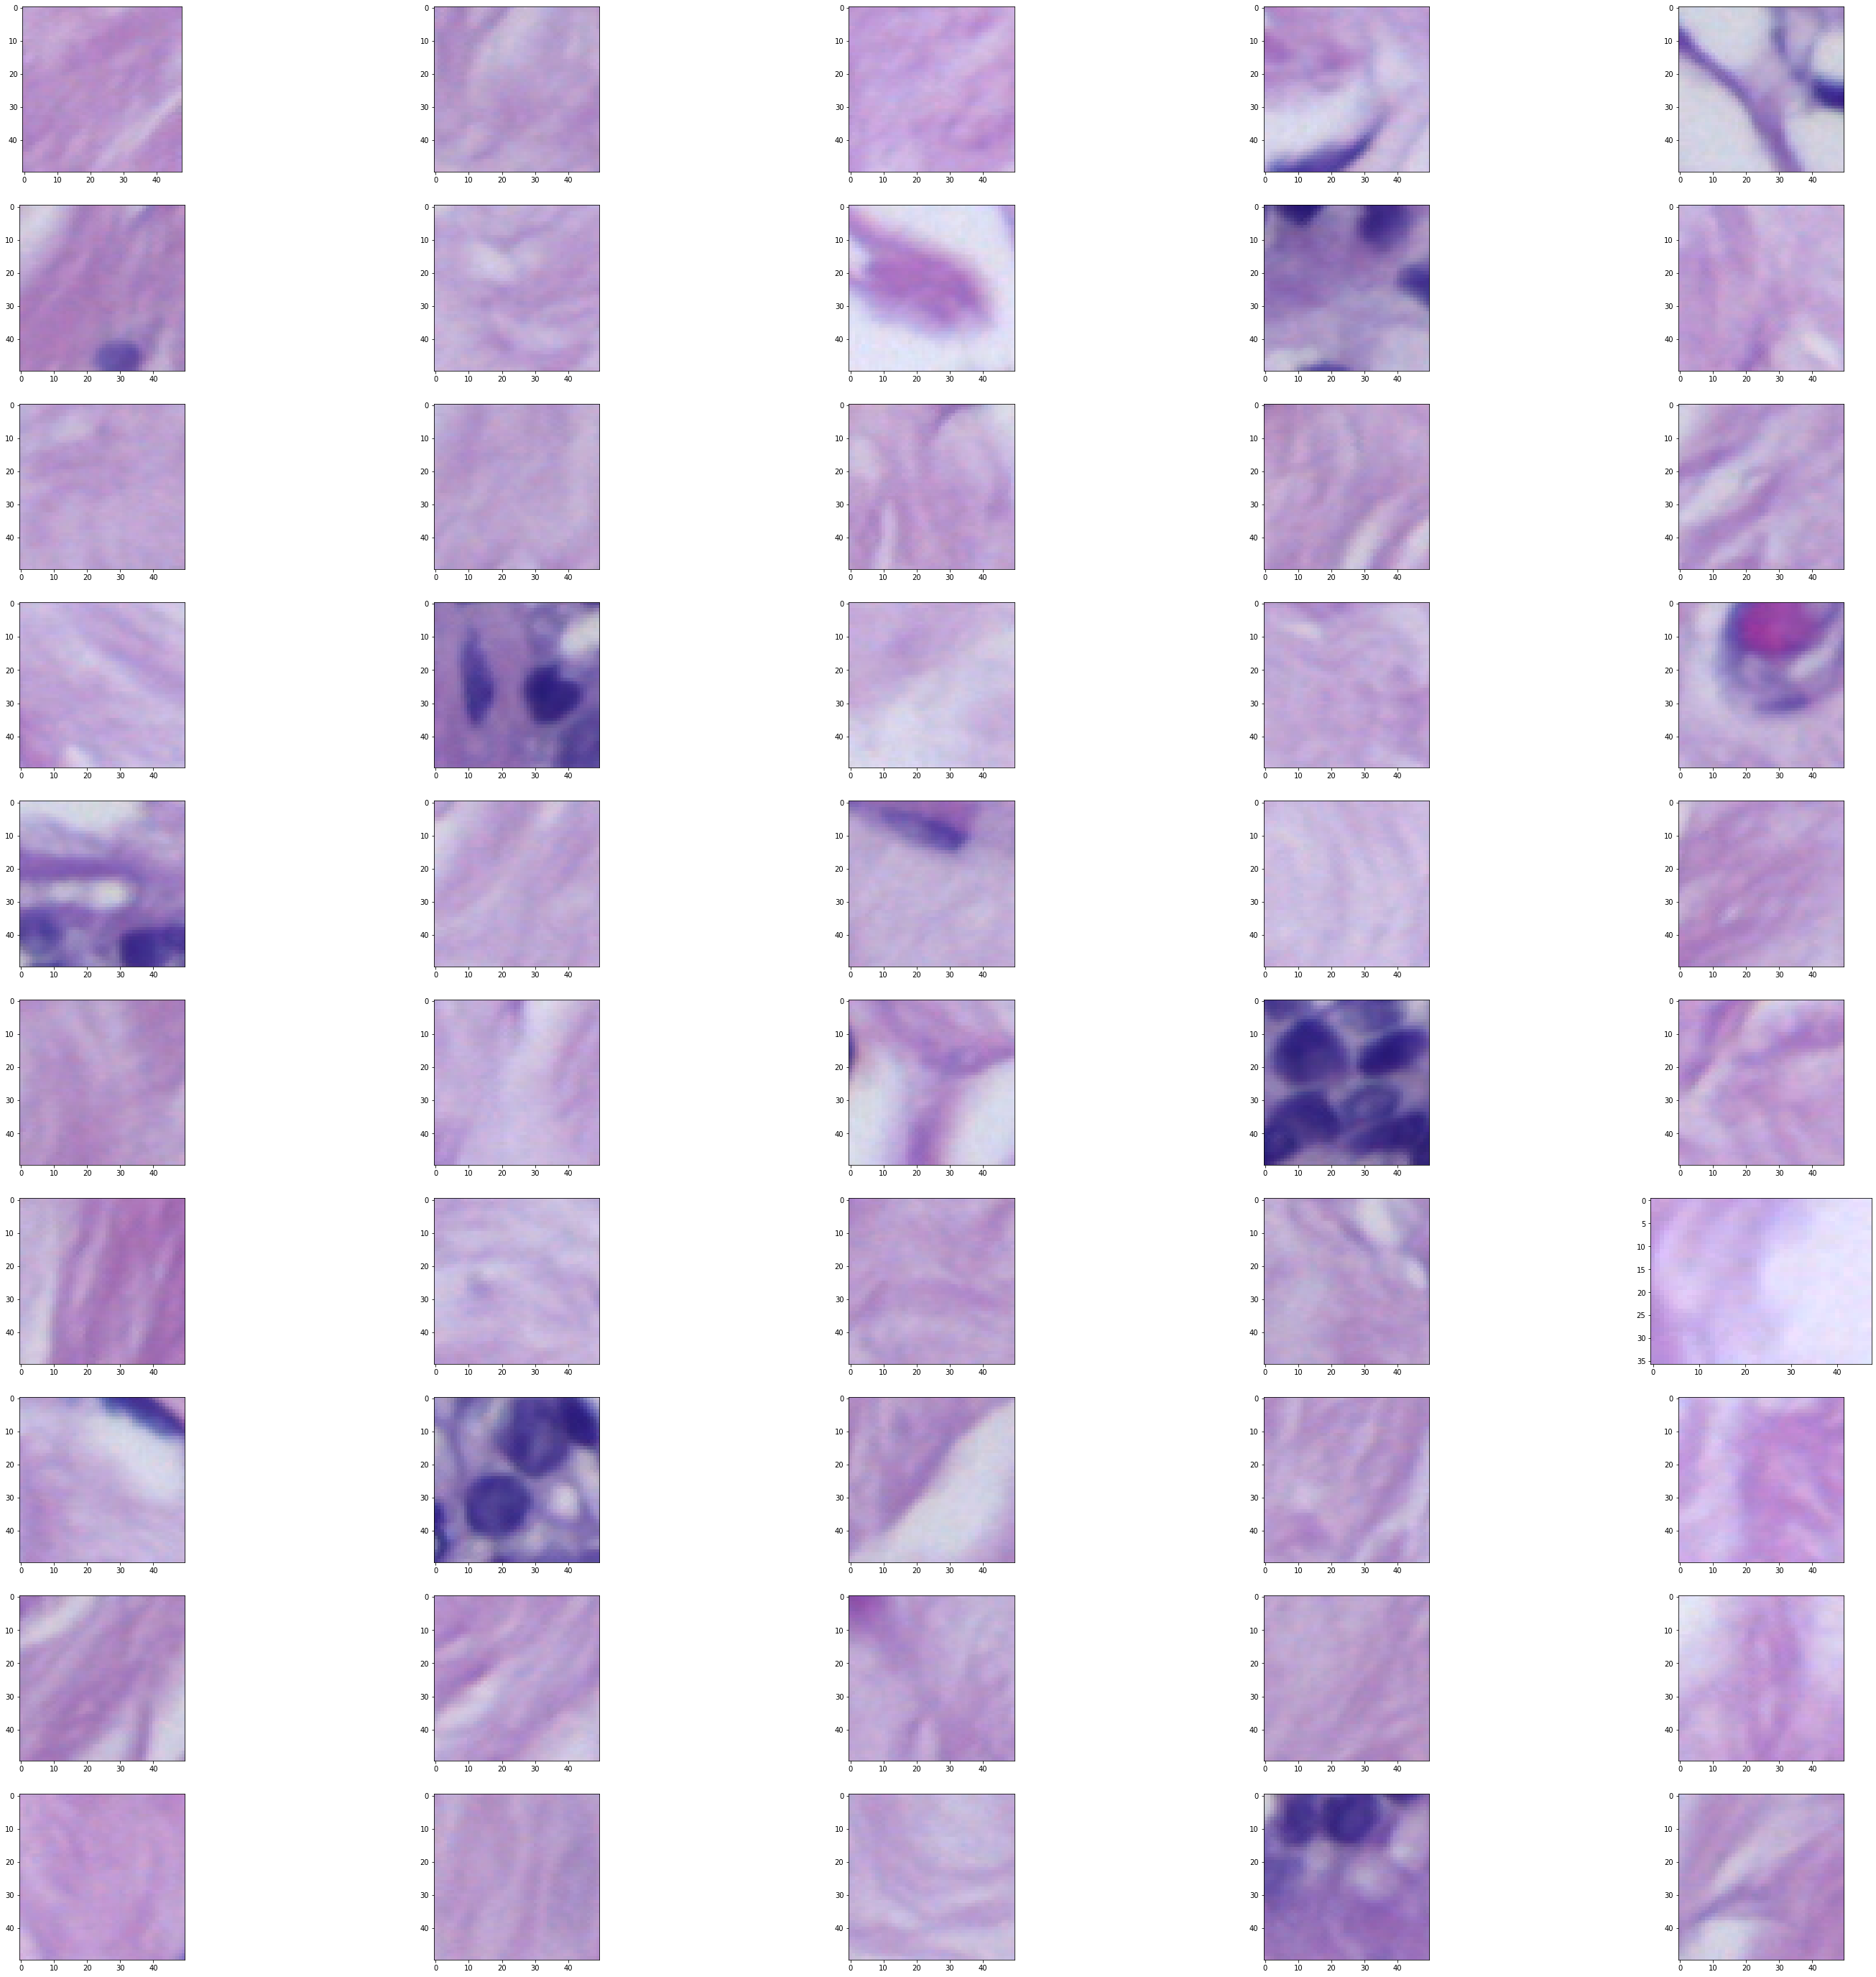

In [7]:
import numpy as np
import h5py
from matplotlib import pyplot as PLT
f = h5py.File("data/final.h5", "r")
data_shape = [1536,2048]
x_max = data_shape[0]/50
y_max = data_shape[1]/50
def chunk_shuffle(lists):
    #lists = [[5,30,25],[27,13,5]]
    #lists[0].sort()
    #lists[1].sort()
    temp = 0
    chunks  = []
    for x in lists[0]:
        y = lists[1][temp]
        temp = temp+1
        if x<x_max and y<y_max:
            chunks.append(f['data'][x*50:(x+1)*50,y*50:(y+1)*50])
        else:
            chunks.append(f['data'][x*50:(data_shape[0]-1),y*50:(data_shape[1]-1)])
    w=50
    h=50
    fig=PLT.figure(figsize=(50, 50))
    columns = 5
    rows = 10
    temp1 = 0
    for i in range(1, columns*rows +1):
        img = np.array(chunks[temp1])
        temp1 = temp1 + 1
        fig.add_subplot(rows, columns, i)
        PLT.imshow(img)
    PLT.show()
lists = QMC(2,50,[x_max,y_max],2)
#print(lists)
chunk_shuffle(lists)


   * **Case 2** :Here we use QMC to generate seed points in the image domain.At each seed point we form rectangular boxes of predefined sizes.So there will be intersections between rectangles.
    
    Here chunk_size=(100,100,3) used for storing the biopsy image data in hdf5 format.
    
    Predefined size = (120,120,3) of the rectangular box
    
    The below figure represents the chunks accessed from the image data matrix using Case2 technique.Where x,y axis represents x and y dimensions of the given biopsy image data matrix.


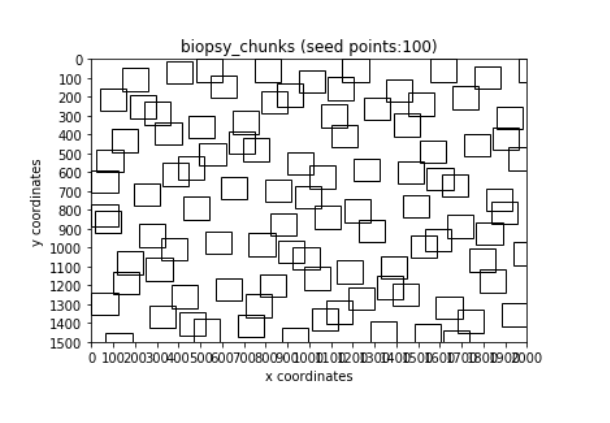

In [8]:
from IPython.display import Image
Image(filename='data/case2.png')

## Multi-level wavelet decomposition:
Let's us view data at different resolutions. we achieve that by ignoring certain levels while applying inverse wavelet transform to reconstruct which inturn affects the resolution.
   * Package used:
        pywavelets(pywt)
    

(1536, 2048, 3)


/home/anil/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


0.9411764705882356


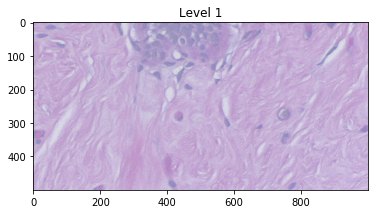

(1536, 2048, 3)


/home/anil/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


0.9576424240794155


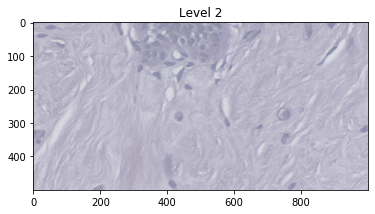

(1536, 2048, 3)


/home/anil/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


0.943798282258856


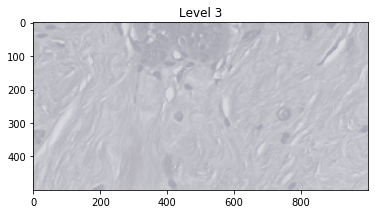

In [9]:
import numpy as np
import pywt
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis
from PIL import Image
import h5py
x = h5py.File("data/final.h5", "r")

bounds = [[500,1000],[1000,2000]]
#print(type(bounds))
def res_red(img,bounds,level,dims):
    if dims == 7:
        print(img['data'].shape)
        c = pywt.wavedecn(img['data'][bounds[0][0]:bounds[1][0],bounds[0][1]:bounds[1][1]], 'db2',level = level)
        for i in range(len(c)):
            if i>1:
                for j in c[i]:
                    c[i][j].fill(0)
        ans = pywt.waverecn(c, 'db2')
        #ans = ans / np.abs(ans).max()
        print(ans.max())
        plt.title("Level {}".format(level))
        plt.imshow(ans)
        plt.show()
        
        

res_red(x,bounds,1,7)
res_red(x,bounds,2,7)
res_red(x,bounds,3,7)


## Pathology

> Word document: https://mahindraecolecentrale-my.sharepoint.com/:w:/g/personal/anilkumar170511_mechyd_ac_in/Ednr6z8AmnJKmUp4yDN_IHABbYVNmaCswHgBzZKj3oyiAg?e=zpuZmA

### Available softwares:
   1. QuPath is a cross-platform software application designed for bioimage analysis - and specifically to meet the needs of whole slide image analysis and digital pathology. It aims to be user-friendly without compromising on power and flexibility, so that it can handle tasks at all levels of complexity: from manually drawing regions and counting structures, to automatically detecting and interactively classifying hundreds of thousands of cells in huge images many gigabytes in size. 
       > Link: https://github.com/qupath/qupath/wiki/What-is-QuPath%3F 

   2. Philips IntelliSite Pathology Solution (PIPS), the first whole slide imaging (WSI) system that allows for review and interpretation of digital surgical pathology slides prepared from biopsied tissue. This is the first time the FDA has permitted the marketing of a WSI system for these purposes. 
       > Link: https://www.fda.gov/news-events/press-announcements/fda-allows-marketing-first-whole-slide-imaging-system-digital-pathology 

All the available software try to import full WSI which is a huge computational and memory constraint.

### Visualization techniques

Digital pathology association suggests a couple of techniques to store and process WSI (whole slide images) 
   > Link: https://digitalpathologyassociation.org/_data/files/Archival_and_Retrieval_in_Digital_pathology_Systems_final.pdf 

   1. The image file associated with a 20X scan of a 15mmx20mm tissue specimen is as large as 3.6GB and a 40X scanned image can be as large as 14.5GB. As we cannot load the whole slide into memory, we can use techniques such as multi-scale analysis or multi-field-of-view approach. 

   2. The images are compressed to more manageable sizes (25:1 compression or greater) such that there is an optimization between image quality, image file size, network bandwidth usage, and server and client resource utilization. For example, the 20X scan could be stored in a JPEG2000-compression file of size 144MB. The 40X image described above could be stored in a JPEG2000-compressed file of size 576MB.  

   3. Multi-scale analysis is a pyramid structure which is saving the whole slides in different levels of resolution which the user can access. Starting from the top level, which represents the subsampled image in the lowest resolution, the analysis moves to the next level (higher resolution) for only part of the image. In the case of whole-slide images, multi-scale analysis is used to achieve efficiency and overcome the memory requirements of large data. Additionally, multi-scale analysis mimics the behavior of the pathologist who starts from the lowest resolution and switches to higher resolutions (zooms in) when necessary, similar to switching to a higher magnification objective lens on a microscope as needed. 

   4. Multi-field-of-view approaches, on the other hand, use the high-resolution WSI for all levels but creates levels by placing several grids on the image to produce different sized blocks. It parallels the field of view of a pathologist on a conventional microscope. 

### Breast biopsy

> Link: Digital Pathology: Diagnostic Errors, 
Viewing Behavior and Image Characteristics: https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/40012/Mercan_washington_0250E_17308.pdf?sequence=1&isAllowed=y 

240 WSIs from the digiPATH dataset are used along with 3 expert oathologusts' ROIs

**Tissue labels**:
1. Epithelium: Ducts and lobules are made up of epithelium cells

    * Benign epithelium:- Line up at the edge of ducts and lobules
    * Malignant epithelium:In DCIS and invasive cases, the epithelial cells are bigger andirregular  in  shape.   These  malignant  epithelial  cells  keep  dividing  and  create  breast carcinomas either in situ or invasive.
  

2. Stroma: Stroma is the supportive tissue that fills between the ducts in the breast. It consists ofconnective tissue, mainly collagen, and the blood vessels. Collagen has a pink appearance inH%E slides. Breast stroma can “react” to the cancer of the ducts. There is research showingthat stromal appearance might affect the survival time in breast cancer

    * Desmoplastic stroma:Desmoplasia is the growth of connective tissue in response tothe presence of the cancer. In the case of breast cancer, desmoplasia is a reaction to thecarcinoma.  The cancer cells cause the proliferation of the fibroblasts and secretion ofcollagen. The tissue is rich with fibroblasts, which appear as smaller cells embedded inthe connective tissue.
    * Normal stroma:We used the label stroma as a blanket term to cover stroma tissue thatis not desmoplastic.


3. Secretion:The ducts and lobules are parts of a glands responsible for producing the milkand deliver it to the nipple. In the case of benign and atypia categories, the ducts and lobulesmight be filled with molecules discharged from the cells.  We used secretion as a label tomark any substance filling the ducts.

4. Necrosis:Necrosis is the death of the cells in the tissue. In the case of breast pathology, thecells in the carcinoma dies due to lack of blood supply caused by the abnormal growth of thetumor cells.  Necrosis usually happens in DCIS cases, close to the center of the duct, whichis filled with proliferating malignant cells.

5. Blood:Although not diagnostically significant, it is common to see vessels and red bloodcells in breast biopsy slides. These are very small regions but are very distinct in appearance

4 categories are used to label the above WSIs

1. Benign
2. Atypia: Abnormal cells in tissues
3. DCIS: Cells that line the milk ducts have cancer. May not spread to other parts.
4. Invasive: Could start as DCIS or start at lobules at spread via lymph vessals

### ROI prediction and classification

More detailed explanation and results are given in
> Link: Digital Pathology: Diagnostic Errors, 
Viewing Behavior and Image Characteristics: https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/40012/Mercan_washington_0250E_17308.pdf?sequence=1&isAllowed=y 

**Visual bag of words**
3600x3600 sliding windows as bags with 120x120 pixel patches as words.
LBP or K-means can be used for the clusturing of words(patches)

**Superpixels and SVM for segmentation**
Superpixels formed for different tissue types and can be classified as ROIs (SLIC)

(300, 300, 3)


(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2f50461e80>)

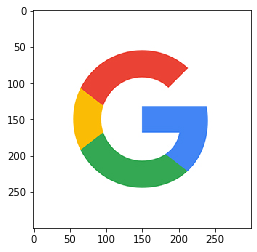

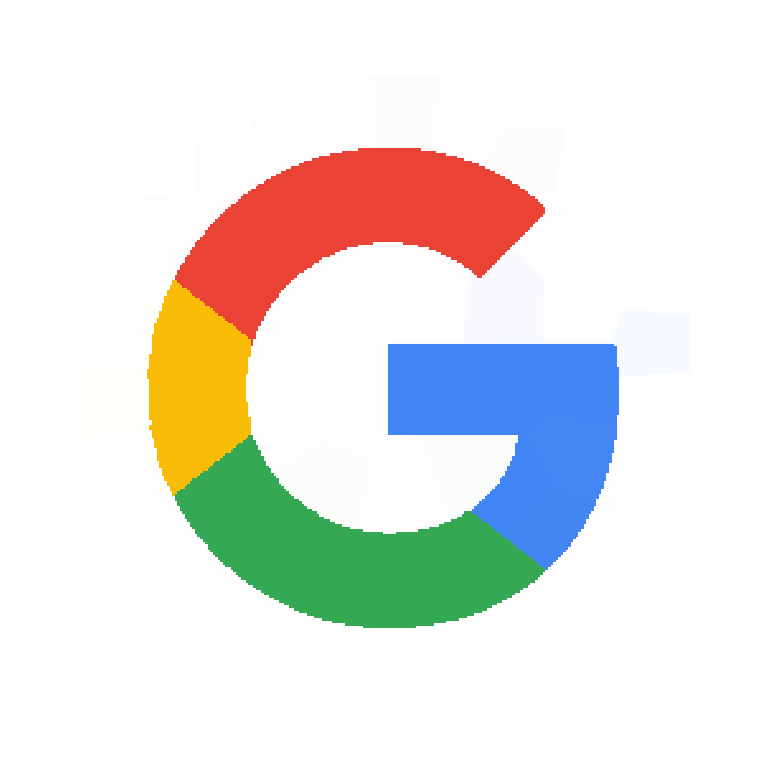

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax
from skimage import io
image = io.imread('data/google.jpg') 
print(image.shape)
plt.imshow(image);
image_slic = seg.slic(image,n_segments=155)
# label2rgb replaces each discrete label with the average interior color
image_show(color.label2rgb(image_slic, image, kind='avg'))


For better ROI formation two larger circles around the region segmenting so as to avoid segmenting minor details and noise.
The accuracy increased when the above is implemented

**Evaluation metrics**
Precision
Recall
Jaccard Index(Intersection over union)

**CNNs for segmentation**
1. Plain network(VGG like implementation)

2. MR-Plain network (Multi resolution version of the same input is used)

3. MR-MP(Multi resolution as above and multi path in decoder)

We propose to use a segmentation network that uses graph based segmentation and also captures very small details such as necrotic cells.

## Python package for big data management

Package that supports multiple files types such as biopsy data,cardiac mr and GEMS

It has three types of functions for every datatype
   * Data conversion to HDF5 format
        * Supports various generic datatypes used for that datatypes
    * Sampling functions
        * Multi level resolution(Downsampling in the case of biopsy data
        * Random chunk access
        * Rectangles formed around random points
        * Random column access
        * Random row access
    * ROI